In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 6.5 MB/s eta 0:00:00


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.


In [3]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import evaluate
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    MistralForSequenceClassification,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)

In [4]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [5]:
class MyDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        super().__init__()
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        text = self.X.iloc[idx]
        #text = self.text.iloc[idx]
        label = self.y.iloc[idx]
        encoding = self.tokenizer(
            text,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        #one_hot_labels = torch.nn.functional.one_hot(label - 1, num_classes=10)
        output = {key: val.squeeze(0) for key, val in encoding.items()}
        output["labels"]= torch.tensor(label,dtype=torch.long)
        #output["label"] =
        return output

In [6]:
# Определяем модель с замороженными эмбеддингами и обучаемым линейным слоем (decision head)
class FrozenTransformerClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(FrozenTransformerClassifier, self).__init__()
        self.transformer = AutoModel.from_pretrained(model_name)
        # Замораживаем параметры трансформера
        for param in self.transformer.parameters():
            param.requires_grad = False

        hidden_size = self.transformer.config.hidden_size
        # Обучаемый линейный слой
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        # Используем представление [CLS] (первый токен)
        cls_output = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(cls_output)
        return logits


In [7]:
data_train = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/train.csv')

In [8]:
data_train = data_train.drop(columns=['Unnamed: 0'])

In [9]:
data_test = pd.read_csv('/content/drive/MyDrive/Znatno_personal/Отчетность ВКР/Артефакты/Parsing_avito/data_test(sp).csv')

In [10]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [11]:
X = data_train['message.text']
y = data_train['Оценка']
X_test = data_test['message.text']
y_test = data_test['Оценка']

In [12]:
def convert_emojis_to_words(text):

    # Convert emojis to words
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove the : from the words and replace _ with space
    text = text.replace("_", " ")

    return text

In [13]:
symbols_pattern = re.compile(pattern = "["
    "@_!#$%^&*()<>?/\|}{~√•—"
                       "]+", flags = re.UNICODE) #спецсимволы
# двойные пробелы
space_pattern = re.compile('\s+')
#exclude = set(string.punctuation) # удаление пунктуации

In [14]:
def clear_text(text):
    """ Функция удаления спецсимволов"""
    # удаление спецсимволов и emoji
    pre = symbols_pattern.sub(r'',text)

    return space_pattern.sub(' ', pre)

In [15]:
def preprocess_text(text):
    """ Финальная функция для обработки """
    # srip + lower + punctuation
    sentence = (
        ''.join([x for x in str(text).strip().lower()])
    )

    return clear_text(sentence)

In [16]:
X = X.apply(preprocess_text)

In [17]:
X_test = X_test.apply(preprocess_text)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FrozenTransformerClassifier(model_name ="ai-forever/ruRoberta-large", num_labels=9)
model.to(device)

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FrozenTransformerClassifier(
  (transformer): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True

In [21]:
from transformers import DataCollatorWithPadding

# ... (rest of your code) ...

# Replace default_data_collator with DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [22]:
f1_metric = evaluate.load("f1")
accuracy_metric = evaluate.load("accuracy")

In [23]:
train_dataset = MyDataset(X_train, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = MyDataset(X_val, y_val, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [24]:
test_dataset = MyDataset(X_test, y_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [25]:
next(iter(train_dataloader))

{'input_ids': tensor([[  101, 26787, 40776,  ...,     0,     0,     0],
         [  101,   877, 58335,  ...,     0,     0,     0],
         [  101, 16174,   156,  ...,     0,     0,     0],
         ...,
         [  101,   100, 10342,  ...,     0,     0,     0],
         [  101, 14198, 39327,  ...,     0,     0,     0],
         [  101, 27668, 30821,  ...,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([2, 3, 5, 5, 7, 4, 8, 7, 4, 8, 2, 7, 5, 7, 0, 3, 5, 7, 4, 3, 8, 5, 5, 8,
         5, 6, 2, 3, 0, 2, 0, 8, 4, 0,

In [26]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    all_preds, all_labels = [], []
    total_loss = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(data_loader), acc, f1

def eval_model(model, data_loader, criterion, device):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(data_loader), acc, f1

## Запуск обучения

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MyDataset(X_train, y_train, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = MyDataset(X_val, y_val, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

model = FrozenTransformerClassifier(model_name = "DeepPavlov/rubert-base-cased", num_labels=9)
model.to(device)

criterion = nn.CrossEntropyLoss()

# Обновляем только параметры классификатора (decision head)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=5e-3)
EPOCHS = 200

train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_f1s = []
val_f1s = []
for epoch in range(EPOCHS):
    train_loss, train_acc, train_f1 = train_epoch(model, train_dataloader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = eval_model(model, val_dataloader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train  Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | F1: {train_f1:.4f}")
    print(f"Val    Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/200
Train  Loss: 1.7636 | Acc: 0.3380 | F1: 0.3273
Val    Loss: 1.5589 | Acc: 0.3959 | F1: 0.3876
Epoch 2/200
Train  Loss: 1.4724 | Acc: 0.4648 | F1: 0.4601
Val    Loss: 1.4362 | Acc: 0.4956 | F1: 0.4953
Epoch 3/200
Train  Loss: 1.3655 | Acc: 0.5160 | F1: 0.5136
Val    Loss: 1.3870 | Acc: 0.4956 | F1: 0.4849
Epoch 4/200
Train  Loss: 1.3446 | Acc: 0.5261 | F1: 0.5224
Val    Loss: 1.2868 | Acc: 0.4868 | F1: 0.4779
Epoch 5/200
Train  Loss: 1.2788 | Acc: 0.5391 | F1: 0.5363
Val    Loss: 1.2982 | Acc: 0.4868 | F1: 0.4803
Epoch 6/200
Train  Loss: 1.2500 | Acc: 0.5538 | F1: 0.5506
Val    Loss: 1.3111 | Acc: 0.4780 | F1: 0.4667
Epoch 7/200
Train  Loss: 1.2189 | Acc: 0.5564 | F1: 0.5569
Val    Loss: 1.2366 | Acc: 0.5308 | F1: 0.5285
Epoch 8/200
Train  Loss: 1.2086 | Acc: 0.5776 | F1: 0.5757
Val    Loss: 1.2222 | Acc: 0.5191 | F1: 0.5002
Epoch 9/200
Train  Loss: 1.1883 | Acc: 0.5678 | F1: 0.5657
Val    Loss: 1.1874 | Acc: 0.5718 | F1: 0.5706
Epoch 10/200
Train  Loss: 1.1736 | Acc: 0.5874

In [27]:
test_loss, test_acc, test_f1 = eval_model(model, val_dataloader, criterion, device)

In [31]:
print(test_acc, test_f1 )

0.6392961876832844 0.6386126675995685


In [28]:
import matplotlib.pyplot as plt

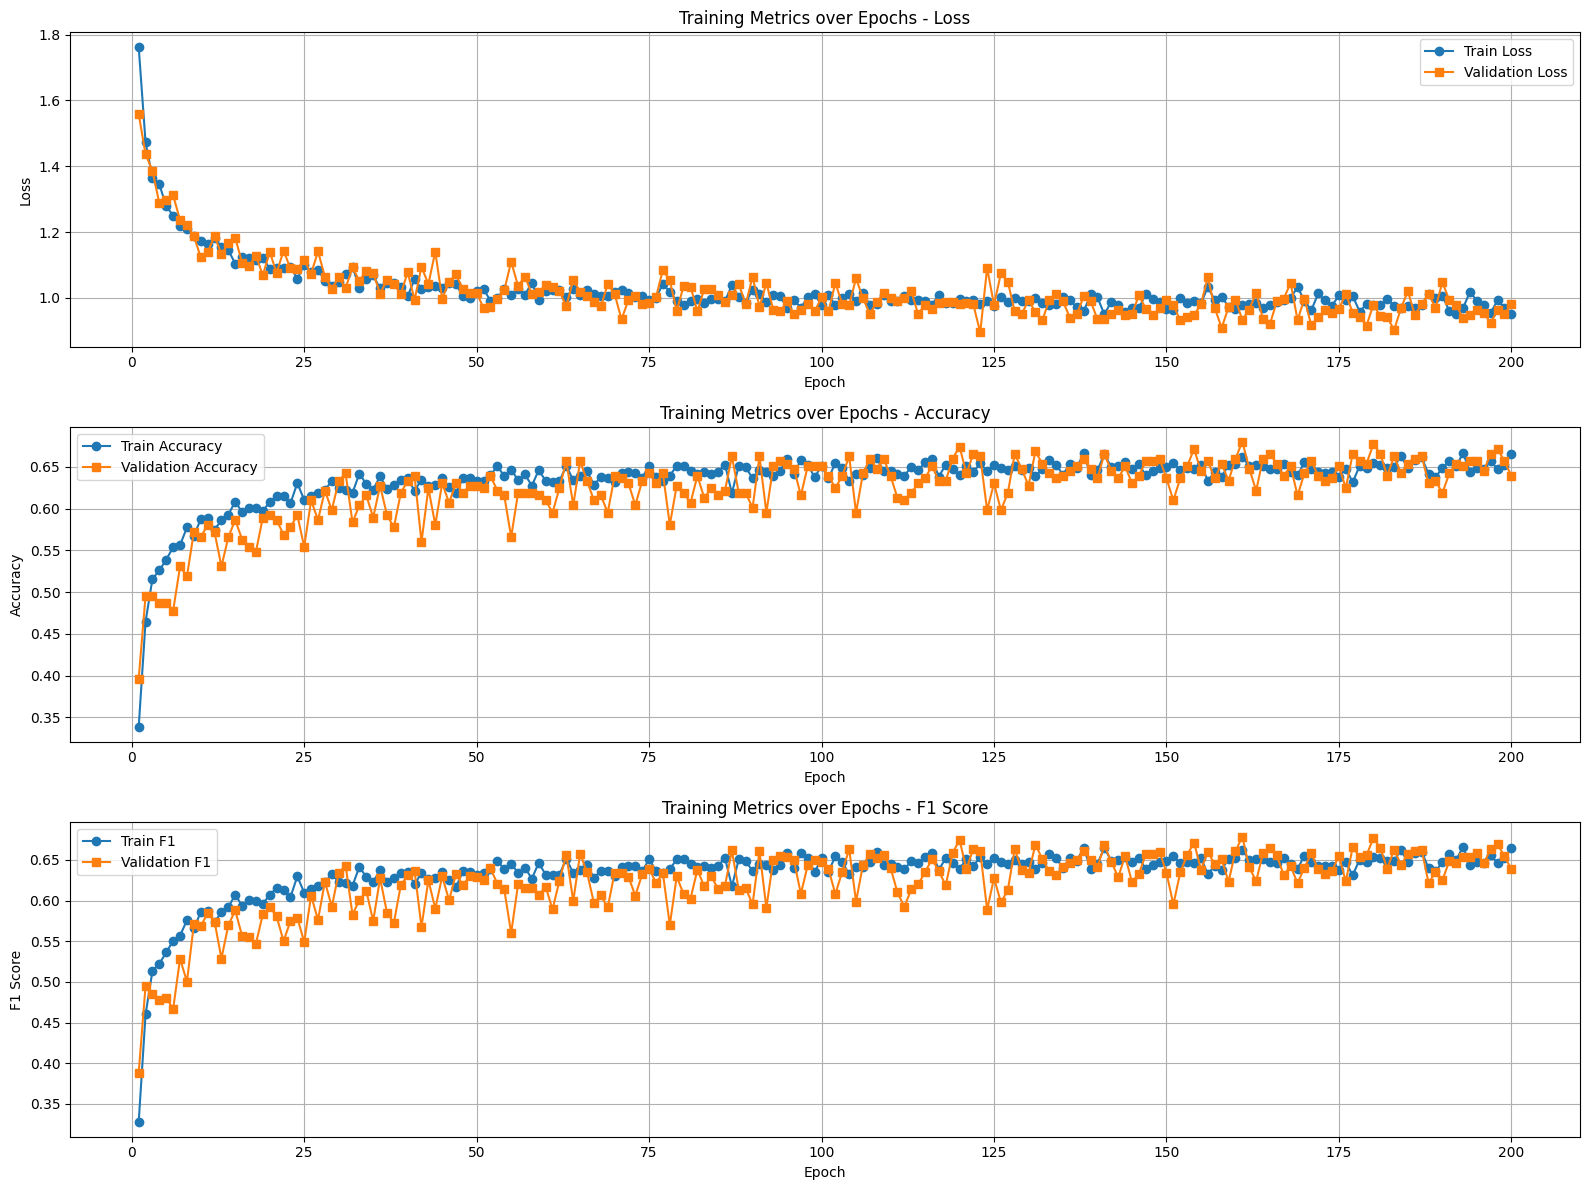

In [29]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s, title='Training Metrics over Epochs'):
    """
    Строит графики функции потерь, accuracy и F1-метрики для трейна и валидации.

    Parameters:
    - train_losses, val_losses: значения loss по эпохам
    - train_accs, val_accs: значения accuracy по эпохам
    - train_f1s, val_f1s: значения F1 по эпохам
    - title: заголовок графика
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(16, 12))

    # Loss
    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accs, label='Validation Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.grid(True)

    # F1 Score
    plt.subplot(3, 1, 3)
    plt.plot(epochs, train_f1s, label='Train F1', marker='o')
    plt.plot(epochs, val_f1s, label='Validation F1', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'{title} - F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Пример использования
example_train_losses = [0.9, 0.7, 0.5, 0.4, 0.35]
example_val_losses = [1.0, 0.8, 0.6, 0.55, 0.5]
example_train_accs = [0.6, 0.7, 0.8, 0.85, 0.88]
example_val_accs = [0.58, 0.68, 0.75, 0.78, 0.8]
example_train_f1s = [0.5, 0.65, 0.75, 0.82, 0.86]
example_val_f1s = [0.48, 0.62, 0.72, 0.76, 0.79]

plot_metrics(train_losses, val_losses,
             train_accs, val_accs,
             train_f1s, val_f1s)
